In [1]:
""" Camila Losada 2024/10/23 """

' Camila Losada 2024/10/23 '

In [2]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath("../utils/inputs.py"))
sys.path.append(os.path.dirname(SCRIPT_DIR))

In [3]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import nest
from utils.capacity import compute_capacity
from utils.extractors import filter_spikes_parallel
import seaborn as sns
import numpy as np
from scipy import sparse
from utils import brn_clustered_network


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Oct 17 2024 16:05:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [4]:
seed = 1
np.random.seed(seed)

In [5]:
def get_sparse_matrix(rows,cols,probability,seed):
    # Set the random seed for reproducibility
    rng = np.random.default_rng(seed)
    # Generate a random sparse matrix with values 0 or 1
    sparse_matrix = sparse.random(rows, cols, density=probability, format='csr', random_state=rng, data_rvs=lambda s: rng.integers(1, 2, size=s))
    # Convert the sparse matrix to a dense format
    dense_matrix = sparse_matrix.toarray()
    return dense_matrix


In [6]:
def extract_results(
    spks,
    filter_tau,
    sim_time,
    NE,
    dt,
    num_threads=1

):
    activity = spks.events
    states = filter_spikes_parallel(
        activity['times'], activity['senders'], 
        NE, 
        t_start=0., t_stop=sim_time, dt=dt, 
        tau=filter_tau, 
        n_processes=num_threads
    )

    return activity, states

### Define parameters

In [7]:
# simulation
sim_time = 10000. # simulation time [ms] (for each epoch)
dt=0.1
# network parameters-----------
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
c_factor=2
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)  
Ntotal=NE+NI
# synapse parameters----------
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)
# Define W matrix
w = 0.1 # excitatory synaptic weight (mV)
w *= np.sqrt(10)
n_clusters = 12
w_factor = 7 # scaling clusters w
wc = [w*w_factor]*n_clusters
w_ex = np.full((NE,NE),w,dtype=np.float64)
nn_c = int(NE/n_clusters)# number of units per cluster
for i_n in range(n_clusters):
    st=i_n*nn_c
    end=(i_n+1)*nn_c
    w_ex[st:end,st:end] = wc[i_n]
w_i = -w*g
w_sparse = get_sparse_matrix(rows=w_ex.shape[0],cols=w_ex.shape[1],probability=0.1,seed=seed)
w_sparse = w_ex*w_sparse

# neuron paramters----------------
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
scalef=0.5
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}
params = {'g':g, 
          'eta':1.0,#set external rate above threshold, 
          'w':w,
          'w_e':w_sparse,
          'w_i':w_i,
          'neuron_params':neuron_params,    
          'NE':NE,
          'NI':NI,
          'CE':int(c_factor*CE),
          'CI':int(c_factor*CI), 
          'NrE':NE, 
          'NrI':NI, 
          'rec_start':0, 
          'rec_stop':sim_time,
          'input_s':'signal',
          'dt':dt,
          'scalef':scalef,
          'seed':seed,
}

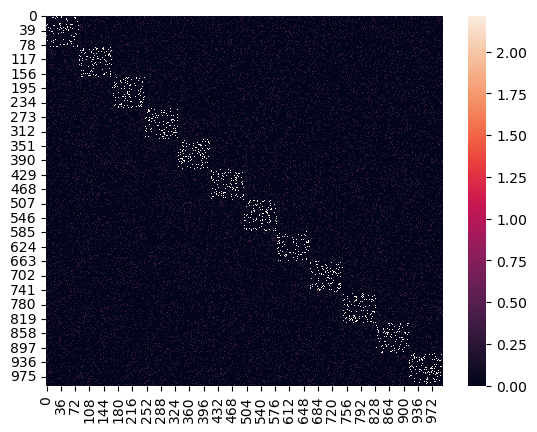

In [8]:
res_name = f"results/{params['input_s']}/sf{params['scalef']}_w{np.round(params['w'],2)}_eta{params['eta']}_w_i{np.round(params['w_i'],2)}_nc{n_clusters}_wf{w_factor}_g{params['g']}_cf{c_factor}"
ff=sns.heatmap(w_sparse)
figure = ff.get_figure()    
figure.savefig(f'{res_name}.png', dpi=400)

### Create and simulate network

In [10]:
num_threads = 4
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,# simulation resolution
    'print_time': True,
    'local_num_threads': num_threads})
network = brn_clustered_network.BrunelClusterNetwork(**params)
network.create_network()
network.generate_input(sim_time)
network.simulate(sim_time)

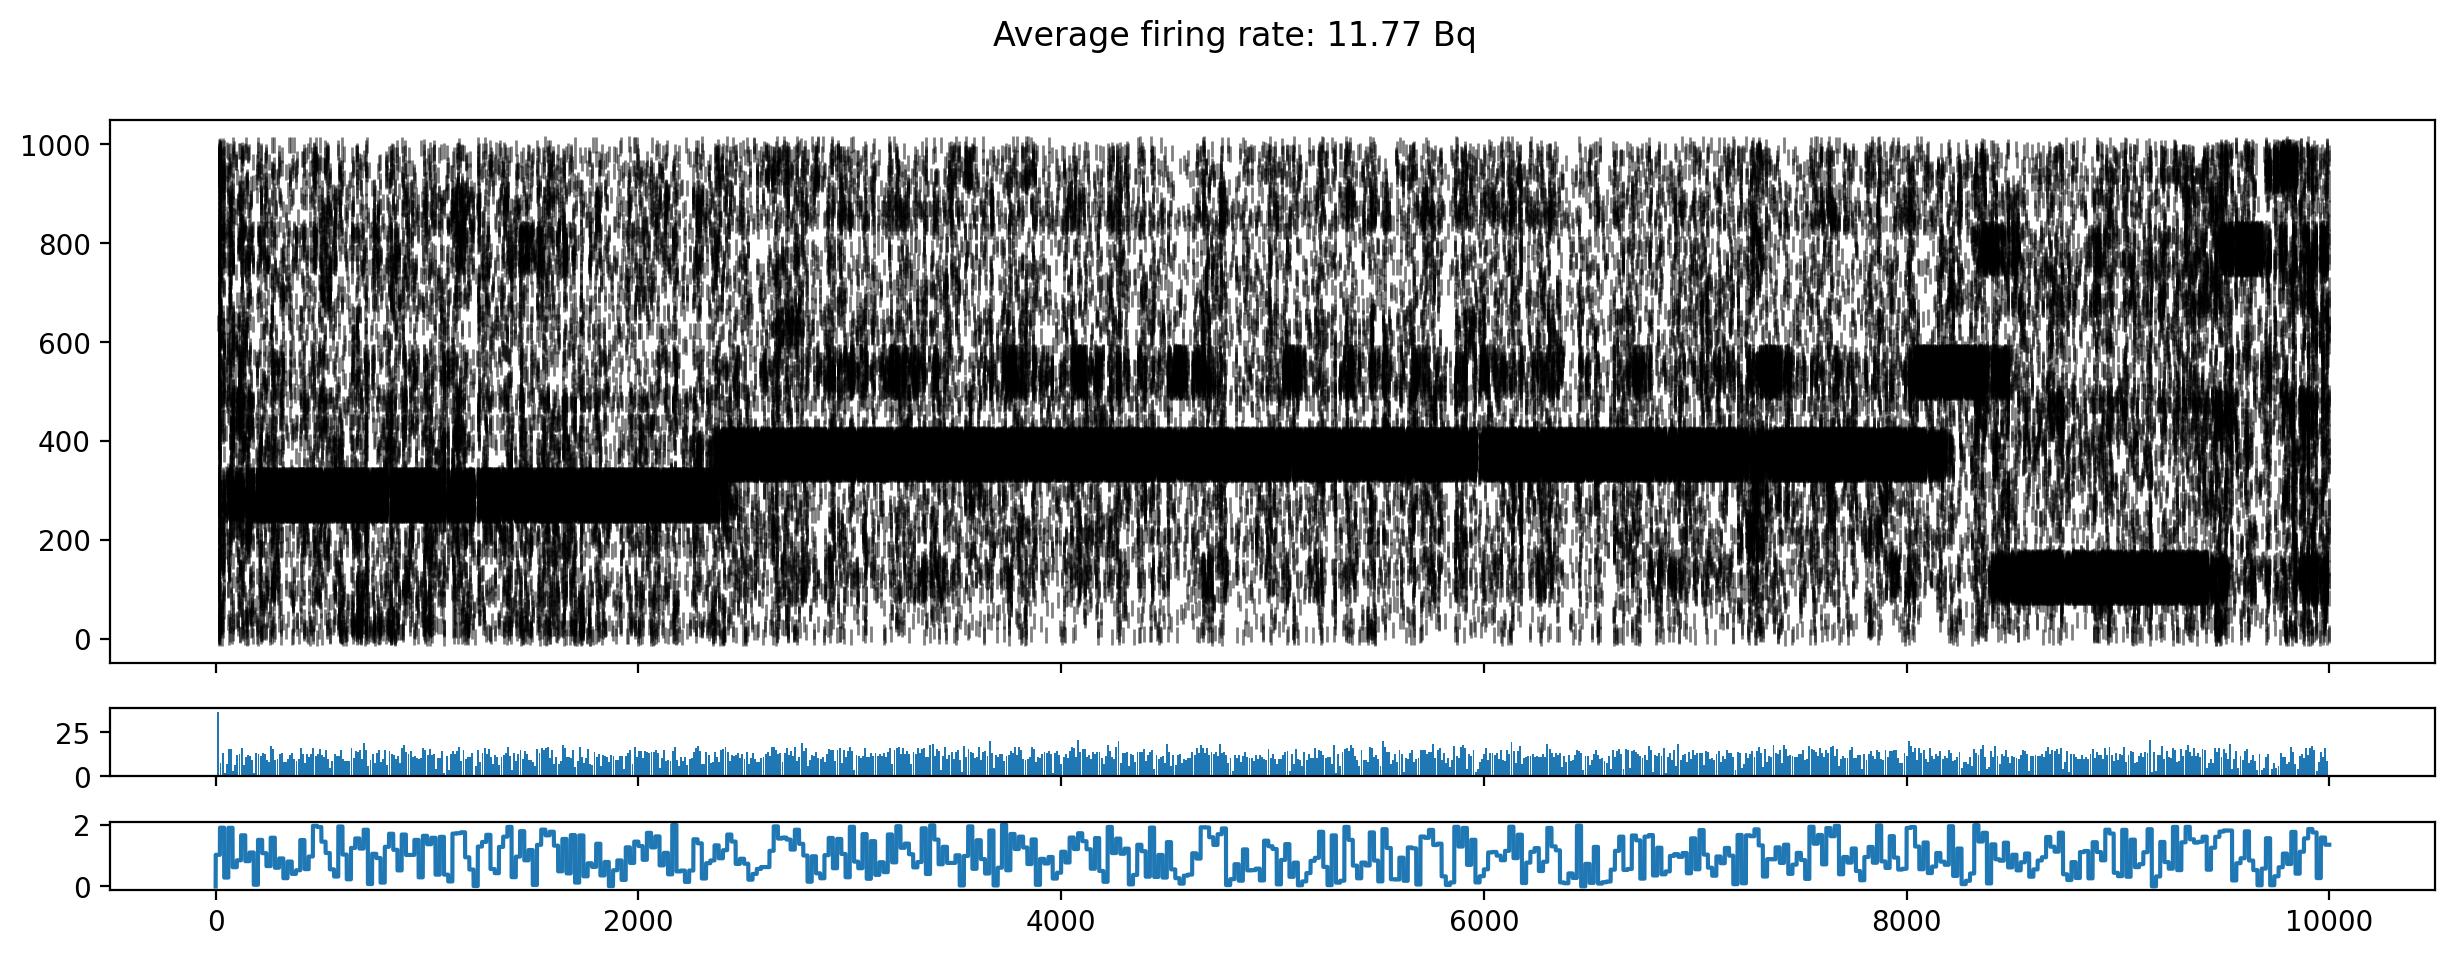

In [11]:
# graphical representation of the main network
ncols=1
nrows=2
gridspec_kw = {"height_ratios":[0.9,0.1]}
if params['input_s']=='signal':
    nrows=3
    gridspec_kw = {"height_ratios":[0.8,0.1,0.1]}
fig,ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(15,5),
    dpi=200,
    gridspec_kw=gridspec_kw,
    sharex=True
)
spikes_ex = network.recorder_ex.events["times"]
sp_senders_ex = network.recorder_ex.events["senders"]
ax[0].plot(
    spikes_ex,
    sp_senders_ex,
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    spikes_ex,
    bins=np.linspace(spikes_ex.min(), spikes_ex.max(), 1_000)
)

ax[1].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)
if params['input_s']=='signal':
    ax[2].plot(
        network.times,
        network.sig
    )
time_diff = (params['rec_stop']-params['rec_start'])/1000.
average_firing_rate = (len(spikes_ex)
                        / time_diff
                        /params['NrE'])
fig.suptitle(f'Average firing rate: {np.round(average_firing_rate,2)} Bq')
fig.savefig(res_name+'raster.png')

In [12]:
filter_tau = 20. # [ms]
activity, states = extract_results(
    spks=network.recorder_ex,
    filter_tau=filter_tau,
    sim_time=sim_time,
    NE=NE,
    dt=dt, 
    num_threads=8)

Filtering SpikeTrains: 100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


In [13]:
estimate, capacity, error = compute_capacity(states, network.sig[1:])
print(f"Network: \n\t- Capacity={capacity}, MSE={error}")


Elapsed time for capacity computation: 40.2928946018219
Network: 
	- Capacity=0.6826109039149301, MSE=0.10425707382703941


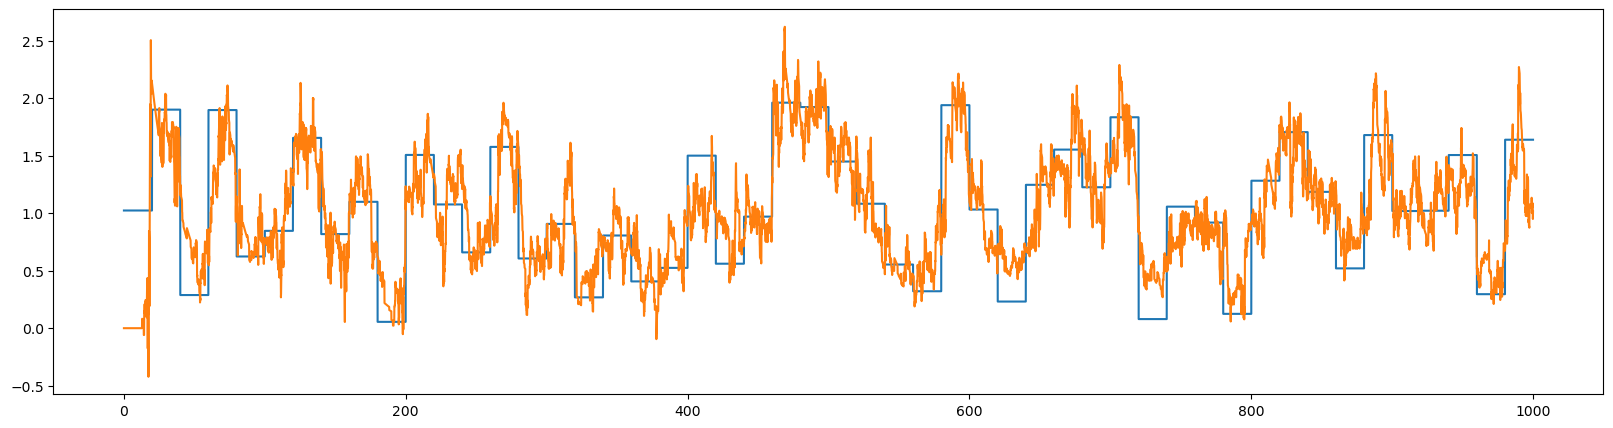

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,5))
ax.plot(network.times[1:10000],network.sig[1:10000])
ax.plot(network.times[1:10000],estimate[:9999])
fig.savefig(res_name+'estimate.png')


Elapsed time for capacity computation: 26.731529235839844

Elapsed time for capacity computation: 16.96334218978882

Elapsed time for capacity computation: 16.934121131896973

Elapsed time for capacity computation: 23.356796264648438

Elapsed time for capacity computation: 27.039628505706787

Elapsed time for capacity computation: 18.08659529685974

Elapsed time for capacity computation: 21.667006731033325

Elapsed time for capacity computation: 16.184560775756836

Elapsed time for capacity computation: 19.881279706954956

Elapsed time for capacity computation: 13.81134843826294

Elapsed time for capacity computation: 19.5279860496521

Elapsed time for capacity computation: 20.363908529281616

Elapsed time for capacity computation: 17.81252121925354

Elapsed time for capacity computation: 18.078081846237183

Elapsed time for capacity computation: 24.444953203201294

Elapsed time for capacity computation: 21.663501977920532

Elapsed time for capacity computation: 16.44760823249817

Ela

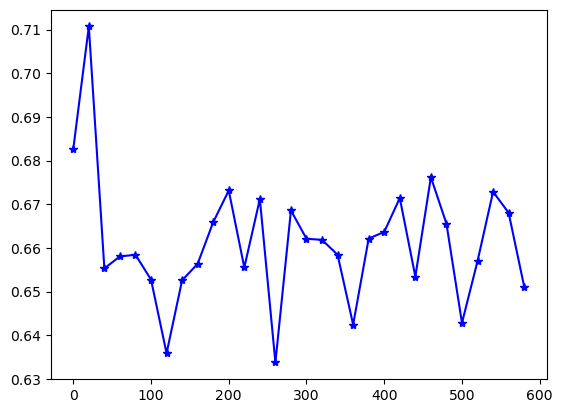

In [15]:
# exclude initial values at time 0.
sig = network.sig[1:]
times = network.times[1:]
max_lag = 600.  # [ms] in this example
step_lag = 20.  # [ms] - if != dt (index the time axis)
time_lags = np.arange(dt, max_lag, step_lag)
time_vector = np.arange(dt, sim_time, dt)
indices = [np.where(time_vector==idx)[0][0] for idx in time_lags]
circuit_capacity = []
for idx, lag in zip(indices, time_lags):
	# shift the target signal
	if idx > 0:
		shifted_signal = sig[:-idx]
	else:
		shifted_signal = sig[:]
	# shift the population states
	circ_st = states[:, idx:]
	# compute capacity
	circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)
	circuit_capacity.append(circ_capacity)
fig,ax1 = plt.subplots()
ax1.plot(time_lags, circuit_capacity,'*b')
ax1.plot(time_lags, circuit_capacity,'b')
fig.savefig(res_name+'total_capacity.png')
plt.show()